In [1]:
import warnings
import pandas as pd
import numpy as np
import networkx as nx

from scipy import stats
from sklearn import preprocessing, metrics
from itertools import combinations

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
warnings.simplefilter('ignore')

In [4]:
def read_ava_test_df(pred_root):
    df, _ = read_preds(pred_root)
    return df[df.split=='test']

In [5]:
def build_ava_cm(pred_root, dst):
    
    df = read_ava_test_df(pred_root)
    domains = list(df.domain.unique())
    df['domain_pred'] = df.apply(lambda r: domains[np.argmax([r[f'p_{d}'] for d in domains])], 1)
    
    labels = list(df.domain.unique())
    cm = metrics.confusion_matrix(df.domain, df.domain_pred, labels=labels)
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(8,6), dpi=100)
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig(dst, bbox_inches='tight')

100%|██████████| 284/284 [00:15<00:00, 18.55it/s]


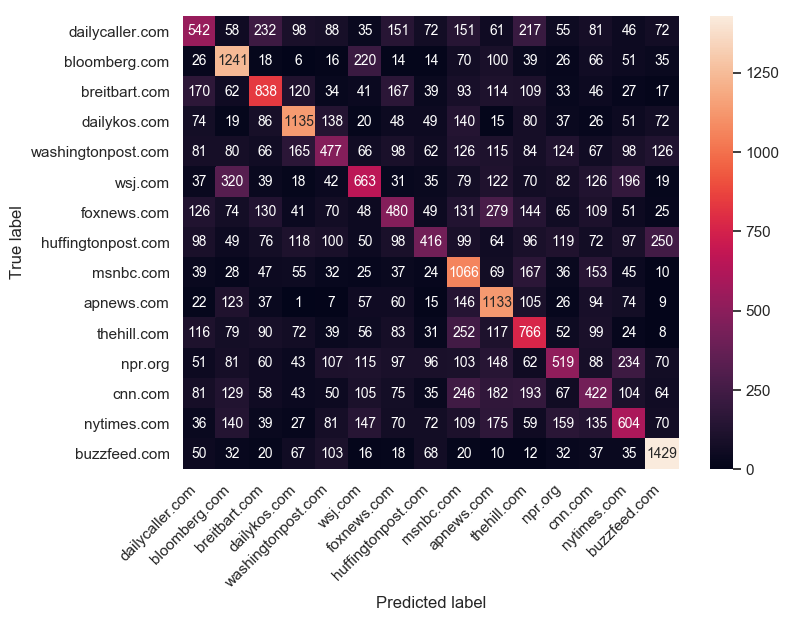

In [6]:
build_ava_cm('../../data/ava-lstm-attn/', 'figures/lstm-cm.png')

In [7]:
lstm_test_df = read_ava_test_df('../../data/ava-lstm-attn/')

100%|██████████| 284/284 [00:15<00:00, 18.91it/s]


In [10]:
', '.join(['%.5f' % w for w in lstm_test_df['p_wsj.com'].head(10)])

'0.10904, 0.16110, 0.00601, 0.00039, 0.01248, 0.00360, 0.00478, 0.08527, 0.00148, 0.01919'

In [11]:
', '.join(['%.5f' % w for w in lstm_test_df['p_bloomberg.com'].head(10)])

'0.08851, 0.32514, 0.00025, 0.00011, 0.01052, 0.00124, 0.07148, 0.19867, 0.00081, 0.00991'

# All-vs-all, confusion counts

In [12]:
def build_ava_cc_df(pred_root, prefix):
    
    df = read_ava_test_df(pred_root)
    domains = list(df.domain.unique())
    df['domain_pred'] = df.apply(lambda r: domains[np.argmax([r[f'p_{d}'] for d in domains])], 1)
    
    rows = []
    for d1 in domains:
        
        d2_count = df[df.domain==d1].groupby('domain_pred').size().to_dict()
    
        for d2, count in d2_count.items():
            if d2 != d1:
                rows.append((d1, d2, count))
    
    return pd.DataFrame(rows, columns=('d1', 'd2', f'{prefix}cc'))

In [14]:
lstm_cc = build_ava_cc_df('../../data/ava-lstm-attn/', 'lstm_')

100%|██████████| 284/284 [00:14<00:00, 19.12it/s]


In [15]:
lstm_cc.sort_values('lstm_cc', ascending=False).head(10)

,d1,d2,lstm_cc
71,wsj.com,bloomberg.com,320
84,foxnews.com,apnews.com,279
149,thehill.com,msnbc.com,252
101,huffingtonpost.com,buzzfeed.com,250
176,cnn.com,msnbc.com,246
164,npr.org,nytimes.com,234
2,dailycaller.com,breitbart.com,232
27,bloomberg.com,wsj.com,220
11,dailycaller.com,thehill.com,217
81,wsj.com,nytimes.com,196


In [16]:
cnn_cc = build_ava_cc_df('../../data/ava-cnn/', 'cnn_')

100%|██████████| 284/284 [00:14<00:00, 19.07it/s]


In [17]:
cnn_cc.sort_values('cnn_cc', ascending=False).head(10)

,d1,d2,cnn_cc
148,thehill.com,msnbc.com,596
49,dailykos.com,msnbc.com,503
175,cnn.com,msnbc.com,460
83,foxnews.com,apnews.com,427
26,bloomberg.com,wsj.com,425
8,dailycaller.com,msnbc.com,375
64,washingtonpost.com,msnbc.com,334
153,npr.org,apnews.com,300
167,cnn.com,apnews.com,294
163,npr.org,nytimes.com,281


In [18]:
cbow_cc = build_ava_cc_df('../../data/ava-cbow/', 'cbow_')

100%|██████████| 284/284 [00:15<00:00, 18.93it/s]


In [19]:
cbow_cc.sort_values('cbow_cc', ascending=False).head(10)

,d1,d2,cbow_cc
84,foxnews.com,apnews.com,394
71,wsj.com,bloomberg.com,323
27,bloomberg.com,wsj.com,263
149,thehill.com,msnbc.com,261
164,npr.org,nytimes.com,259
168,cnn.com,apnews.com,256
101,huffingtonpost.com,buzzfeed.com,255
154,npr.org,apnews.com,246
182,nytimes.com,apnews.com,227
50,dailykos.com,msnbc.com,227


# All-vs-all, pcorr

In [20]:
def mirror_d1d2_iter(df):
    for r1 in df.to_dict('records'):
        yield r1
        r2 = r1.copy()
        r2['d1'], r2['d2'] = r2['d2'], r2['d1']
        yield r2

In [21]:
def mirror_d1d2(df):
    return pd.DataFrame(list(mirror_d1d2_iter(df)))

In [22]:
def build_ava_pcorr_df(pred_root, prefix):
    
    df = read_ava_test_df(pred_root)
    pairs = [sorted(p) for p in combinations(df.domain.unique(), 2)]
    
    rows = []
    for d1, d2 in pairs:
    
        p1 = df[f'p_{d1}']
        p2 = df[f'p_{d2}']

        sp, _ = stats.spearmanr(p1, p2)
        kt, _ = stats.kendalltau(p1, p2)
        pr, _ = stats.pearsonr(p1, p2)

        rows.append((d1, d2, sp, kt, pr))
        
    cols = ('d1', 'd2', f'{prefix}sp', f'{prefix}kt', f'{prefix}pr')
    res = pd.DataFrame(rows, columns=cols)
    
    return mirror_d1d2(res)

In [23]:
lstm_pcorr = build_ava_pcorr_df('../../data/ava-lstm-attn/', 'lstm_pcorr_')

100%|██████████| 284/284 [00:15<00:00, 11.25it/s]


In [24]:
lstm_pcorr.sort_values('lstm_pcorr_kt', ascending=False).head(10)

,d1,d2,lstm_pcorr_kt,lstm_pcorr_pr,lstm_pcorr_sp
34,bloomberg.com,wsj.com,0.599171,0.304366,0.791080
35,wsj.com,bloomberg.com,0.599171,0.304366,0.791080
200,npr.org,nytimes.com,0.548110,0.280539,0.736382
201,nytimes.com,npr.org,0.548110,0.280539,0.736382
2,breitbart.com,dailycaller.com,0.529524,0.224462,0.717404
3,dailycaller.com,breitbart.com,0.529524,0.224462,0.717404
135,wsj.com,nytimes.com,0.515378,0.179151,0.700294
134,nytimes.com,wsj.com,0.515378,0.179151,0.700294
171,thehill.com,msnbc.com,0.480935,0.129716,0.666702
170,msnbc.com,thehill.com,0.480935,0.129716,0.666702


In [25]:
cnn_pcorr = build_ava_pcorr_df('../../data/ava-cnn/', 'cnn_pcorr_')

100%|██████████| 284/284 [00:14<00:00, 25.09it/s]


In [26]:
cnn_pcorr.sort_values('cnn_pcorr_kt', ascending=False).head(10)

,cnn_pcorr_kt,cnn_pcorr_pr,cnn_pcorr_sp,d1,d2
34,0.627786,0.477877,0.817191,bloomberg.com,wsj.com
35,0.627786,0.477877,0.817191,wsj.com,bloomberg.com
167,0.588321,0.182927,0.766726,huffingtonpost.com,buzzfeed.com
166,0.588321,0.182927,0.766726,buzzfeed.com,huffingtonpost.com
200,0.535151,0.387539,0.724021,npr.org,nytimes.com
201,0.535151,0.387539,0.724021,nytimes.com,npr.org
2,0.520772,0.256858,0.706771,breitbart.com,dailycaller.com
3,0.520772,0.256858,0.706771,dailycaller.com,breitbart.com
171,0.487995,0.227220,0.673175,thehill.com,msnbc.com
170,0.487995,0.227220,0.673175,msnbc.com,thehill.com


In [27]:
cbow_pcorr = build_ava_pcorr_df('../../data/ava-cbow/', 'cbow_pcorr_')

100%|██████████| 284/284 [00:15<00:00, 18.87it/s]


In [28]:
cbow_pcorr.sort_values('cbow_pcorr_kt', ascending=False).head(10)

,cbow_pcorr_kt,cbow_pcorr_pr,cbow_pcorr_sp,d1,d2
34,0.627633,0.503249,0.818293,bloomberg.com,wsj.com
35,0.627633,0.503249,0.818293,wsj.com,bloomberg.com
2,0.496711,0.321894,0.681251,breitbart.com,dailycaller.com
3,0.496711,0.321894,0.681251,dailycaller.com,breitbart.com
201,0.490291,0.321455,0.672273,nytimes.com,npr.org
200,0.490291,0.321455,0.672273,npr.org,nytimes.com
171,0.473864,0.240569,0.656633,thehill.com,msnbc.com
170,0.473864,0.240569,0.656633,msnbc.com,thehill.com
166,0.472452,0.157228,0.646801,buzzfeed.com,huffingtonpost.com
167,0.472452,0.157228,0.646801,huffingtonpost.com,buzzfeed.com


# A-vs-B, accuracy

In [29]:
ab_acc = pd.DataFrame(read_json_gz_lines('../../data/clf-ab-acc.json/'))
ab_acc = ab_acc.rename(columns={'acc_lr': 'lr_ab_acc', 'acc_svc': 'svc_ab_acc'})
ab_acc['label'] = ab_acc[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

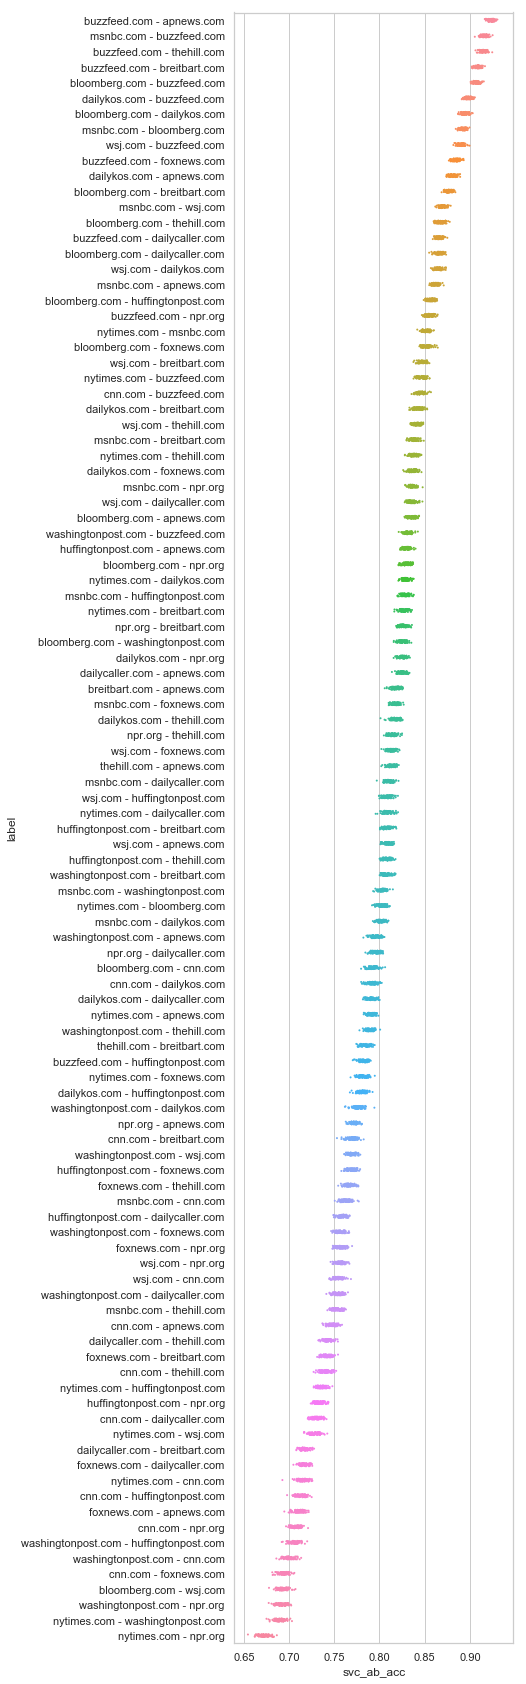

In [30]:
order = ab_acc.groupby('label').mean().svc_ab_acc.sort_values(ascending=False).index
plt.figure(figsize=(5,30))
sns.stripplot(x='svc_ab_acc', y='label', data=ab_acc, order=order, s=2)

In [31]:
ab_acc_mean = ab_acc.groupby(['d1', 'd2']).mean().reset_index()
ab_acc_mean = mirror_d1d2(ab_acc_mean)

In [32]:
ab_acc_mean.sort_values('svc_ab_acc').head(10)

,d1,d2,lr_ab_acc,svc_ab_acc
156,nytimes.com,npr.org,0.664256,0.672518
157,npr.org,nytimes.com,0.664256,0.672518
161,washingtonpost.com,nytimes.com,0.689876,0.689749
160,nytimes.com,washingtonpost.com,0.689876,0.689749
184,washingtonpost.com,npr.org,0.681471,0.691095
185,npr.org,washingtonpost.com,0.681471,0.691095
23,wsj.com,bloomberg.com,0.686796,0.693534
22,bloomberg.com,wsj.com,0.686796,0.693534
50,cnn.com,foxnews.com,0.684600,0.693840
51,foxnews.com,cnn.com,0.684600,0.693840


# A-vs-B, confusion

In [33]:
rows_lr, rows_svc = [], []
for r in read_json_gz_lines('../../data/clf-ab-cm.json'):
    rows_lr += r['cm_lr']
    rows_svc += r['cm_svc']

In [34]:
lr_ab_cc = pd.DataFrame(rows_lr)
svc_ab_cc = pd.DataFrame(rows_svc)

In [35]:
lr_ab_cc = lr_ab_cc.rename(columns={'count': 'lr_ab_cc'})
svc_ab_cc = svc_ab_cc.rename(columns={'count': 'svc_ab_cc'})

In [36]:
svc_ab_cc_mean = svc_ab_cc.groupby(['d1', 'd2']).mean().reset_index()
lr_ab_cc_mean = lr_ab_cc.groupby(['d1', 'd2']).mean().reset_index()

In [37]:
svc_ab_cc_mean.sort_values('svc_ab_cc', ascending=False).head(10)

,d1,d2,svc_ab_cc
166,nytimes.com,washingtonpost.com,2228.08
68,cnn.com,washingtonpost.com,2173.36
152,npr.org,washingtonpost.com,1990.88
124,huffingtonpost.com,washingtonpost.com,1844.88
62,cnn.com,foxnews.com,1811.73
63,cnn.com,huffingtonpost.com,1807.47
164,nytimes.com,npr.org,1797.42
60,cnn.com,dailycaller.com,1778.57
65,cnn.com,npr.org,1746.09
197,wsj.com,bloomberg.com,1738.50


# Combined metrics

In [38]:
df = (lstm_cc
    .merge(cnn_cc)
    .merge(cbow_cc)
    .merge(lstm_pcorr)
    .merge(cnn_pcorr)
    .merge(cbow_pcorr)
    .merge(ab_acc_mean)
    .merge(svc_ab_cc_mean)
    .merge(lr_ab_cc_mean))

In [39]:
metrics = set(df.columns) - {'d1', 'd2'}

Group on `d1`, scale scores with other outlets.

In [40]:
for col in metrics:
    df[col] = df.groupby('d1')[col].transform(preprocessing.scale)

Flip sign on accuracies.

In [41]:
for col in metrics:
    if col.endswith('_acc'):
        df[col] = -df[col]

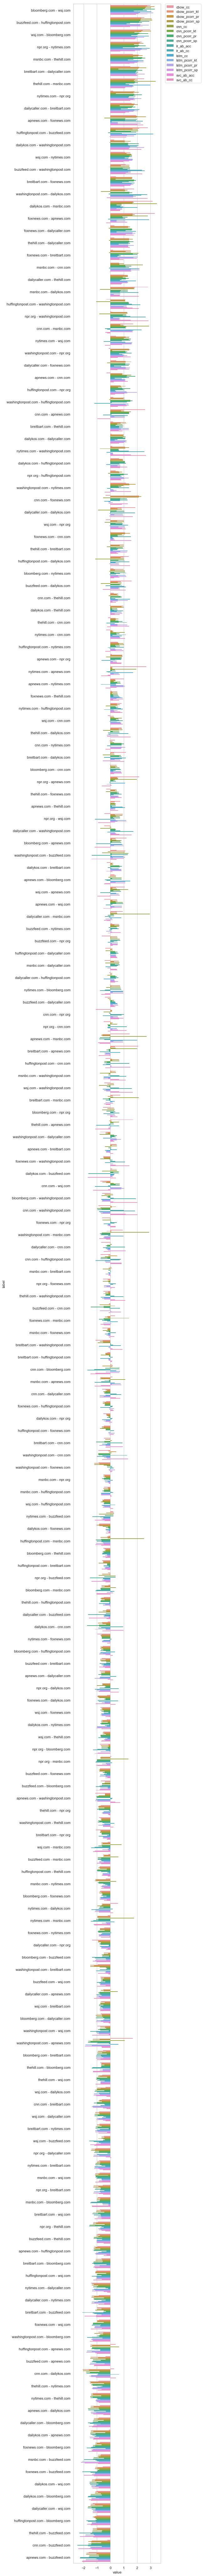

In [42]:
df_melted = df.melt(['d1', 'd2'], set(df.columns) - {'d1', 'd2'})
df_melted['label'] = df_melted[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)
df_melted = df_melted.sort_values('variable')

# Sort by mean score.
order = df_melted.groupby('label').mean().sort_values('value', ascending=False).index

plt.figure(figsize=(5,150))
ax = sns.barplot(x='value', y='label', data=df_melted, hue='variable', order=order, linewidth=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('figures/hl-graph-bars-all-metrics.png', bbox_inches='tight')

In [43]:
df.to_json('data/hl-graph.json', orient='records', lines=True)

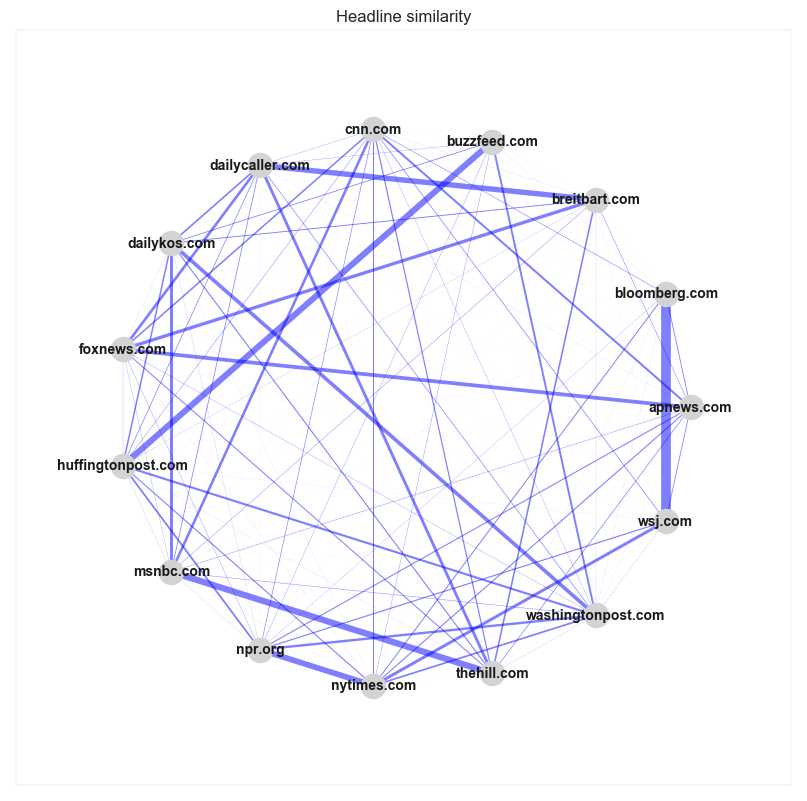

In [44]:
graph_df = df.copy()
graph_df['mean_score'] = graph_df.apply(lambda r: np.mean([r[m] for m in metrics]), 1)
graph_df['pair'] = graph_df.apply(lambda r: tuple(sorted([r.d1, r.d2])), 1)
graph_df = graph_df.groupby('pair').mean()
graph_df['width'] = (preprocessing.minmax_scale(graph_df.mean_score, (0,1))**3)*7

g = nx.Graph()
for r in graph_df.itertuples():
    g.add_edge(r.Index[0], r.Index[1], width=r.width)
    
edge_width = [d['width'] for _, _, d in g.edges(data=True)]

plt.figure(figsize=(10,10), dpi=100)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, width=edge_width, alpha=0.5, edge_color='blue')
_ = nx.draw_networkx_labels(g, pos, font_weight='bold', font_size=10)
plt.savefig('figures/hl-graph-radial-all-metrics.png', bbox_inches='tight')